In [1]:
%matplotlib inline

import sys, os

import numpy as np
import matplotlib.pyplot as plt

import toy_osc_analysis_with_ultrasurfaces
from utils.plotting.standard_modules import *

<< PISA_TARGET env var is defined as: "cpu"; PISA is running in double precision (FP64) mode; numba is running on CPU (single core) >>


## Create systematic sets
We create systematic sets with on-axis and off-axis variations of `scale` and `shape` as we usually would if we were fitting hypersurfaces.

In [2]:
nominal_set = {"scale": 1.0, "shape": 0.3}
# decrease size of variations to make linear approx. work better
sys_sets = [
    # on-axis variations
    {"scale": 1.05, "shape": 0.3},
    {"scale": 0.95, "shape": 0.3},
    {"scale": 1.0, "shape": 0.25},
    {"scale": 1.0, "shape": 0.35},
    # off-axis variations
    {"scale": 1.05, "shape": 0.25},
    {"scale": 1.05, "shape": 0.35},
    {"scale": 0.95, "shape": 0.25},
    {"scale": 0.95, "shape": 0.35},
]

for dataset in sys_sets + [nominal_set]:
    model = toy_osc_analysis_with_ultrasurfaces.ToyOscAnalysisUltrasurf(
        num_mc_events=100000, num_data_events=100000, dropout=True
    )
    model.reco_energy_bins = np.geomspace(10., 100., 25)
    dataset["events"] = model.generate_mc_events(
        random_state=np.random.RandomState(seed=0), **dataset
    )
    dataset["template"] = model.get_template()
    dataset["model"] = model

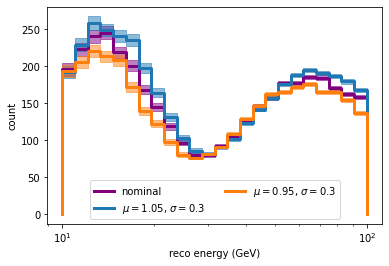

In [3]:
%matplotlib inline
fig = Figure(figsize=(6, 4))
ax = fig.get_ax()

plot_hist(ax=ax, hist=nominal_set["template"],
          label="nominal", color="purple", errors="band")

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for i, dataset in enumerate(sys_sets[:2]):
    plot_hist(
        ax=ax, hist=dataset["model"].get_template(),
        label=fr"$\mu = {dataset['scale']}$, $\sigma={dataset['shape']}$",
        color=colors[i],
        errors="band"
    )
plt.legend(ncol=2, fontsize=10)
ax.set_xlabel("reco energy (GeV)")
ax.set_ylabel("count")
ax.set_xscale("log")
# plt.savefig("systematic_sets_scale.pdf")

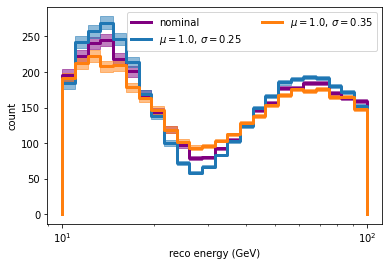

In [4]:
%matplotlib inline
fig = Figure(figsize=(6, 4))
ax = fig.get_ax()

plot_hist(ax=ax, hist=nominal_set["template"],
          label="nominal", color="purple", errors="band")

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for i, dataset in enumerate(sys_sets[2:4]):
    plot_hist(
        ax=ax, hist=dataset["model"].get_template(),
        label=fr"$\mu = {dataset['scale']}$, $\sigma={dataset['shape']}$",
        color=colors[i],
        errors="band"
    )
plt.legend(ncol=2, fontsize=10)
ax.set_xlabel("reco energy (GeV)")
ax.set_ylabel("count")
ax.set_xscale("log")

In [5]:
import pandas as pd

df_sys = [
    pd.DataFrame({
        "true_energy": sys_set["model"].events["true_energy"].astype(np.float32),
        "reco_energy": sys_set["model"].events["reco_energy"].astype(np.float32),
        "reference_weights": sys_set["model"].events["reference_weights"].astype(np.float32),
        "set": i
    }) for i, sys_set in enumerate([nominal_set] + sys_sets)
]
df_all = pd.concat(df_sys, ignore_index=True)

In [6]:
df_all

,true_energy,reco_energy,reference_weights,set
0,587.986755,998.166565,0.008464,0
1,39.720741,44.787125,0.035026,0
2,22.322433,29.940544,0.012202,0
3,33.900597,66.400238,0.020431,0
4,73.104897,128.016968,0.049613,0
...,...,...,...,...
899995,147.930222,202.740234,0.031350,8
899996,97.262772,56.050735,0.043066,8
899997,5.389289,4.468573,0.122581,8
899998,13.145469,13.897813,0.378270,8


[ WARNING] /afs/ifh.de/group/amanda/scratch/trettin/fridge3/pyenv3.7/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"



<AxesSubplot:xlabel='true_energy', ylabel='Count'>

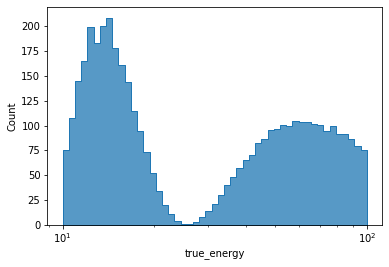

In [8]:
import seaborn as sns
bins = np.linspace(1, 2, 50)
sns.histplot(
    df_all[df_all["set"] == 0],
    x="true_energy",
    weights="reference_weights",
    log_scale=True,
    bins=bins,
    element="step"
)

In [9]:
# define the constant delta-param matrix, containing the
# positions of the systematic sets in parameter space.
# The dimensions are (number of systematic parameter (mu and sigma), number of sets (K))

D = 2  # input dimensions
K = 9  # classes (here: systematic sets)


delta_p = np.zeros((2, K), dtype=np.float32)
sig_nom = 0.3
mu_nom = 1.0

for i, dataset in enumerate([nominal_set] + sys_sets):
    delta_p[0, i] = dataset["scale"] - mu_nom
    delta_p[1, i] = dataset["shape"] - sig_nom
delta_p

array([[ 0.  ,  0.05, -0.05,  0.  ,  0.  ,  0.05,  0.05, -0.05, -0.05],
       [ 0.  ,  0.  ,  0.  , -0.05,  0.05, -0.05,  0.05, -0.05,  0.05]],
      dtype=float32)

In [10]:
from sklearn import preprocessing

poly = preprocessing.PolynomialFeatures(2, include_bias=False, interaction_only=False)

delta_p_poly = poly.fit_transform(delta_p.T).T * 10.
delta_p_poly

array([[ 0.   ,  0.5  , -0.5  ,  0.   ,  0.   ,  0.5  ,  0.5  , -0.5  ,
        -0.5  ],
       [ 0.   ,  0.   ,  0.   , -0.5  ,  0.5  , -0.5  ,  0.5  , -0.5  ,
         0.5  ],
       [ 0.   ,  0.025,  0.025,  0.   ,  0.   ,  0.025,  0.025,  0.025,
         0.025],
       [ 0.   ,  0.   , -0.   , -0.   ,  0.   , -0.025,  0.025,  0.025,
        -0.025],
       [ 0.   ,  0.   ,  0.   ,  0.025,  0.025,  0.025,  0.025,  0.025,
         0.025]], dtype=float32)

### Build and train the classifier

In [11]:
from sklearn import preprocessing
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from skorch import NeuralNetClassifier

trafo = make_column_transformer(
    (
        make_pipeline(
            preprocessing.PowerTransformer()
        ), ["reco_energy", "true_energy"]
    )
)

In [12]:
X_transformed = trafo.fit_transform(df_all)

[ WARNING] /afs/ifh.de/group/amanda/scratch/trettin/fridge3/pyenv3.7/lib/python3.7/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)



In [13]:
X_transformed

array([[ 2.9114537 ,  2.5035512 ],
       [-0.30724555, -0.45442948],
       [-0.72676843, -1.0829246 ],
       ...,
       [-2.6104171 , -2.5585814 ],
       [-1.5154077 , -1.6502115 ],
       [-1.1394798 , -0.54485697]], dtype=float32)

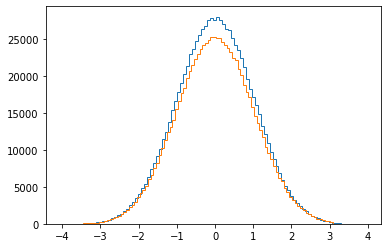

In [14]:
plt.hist(X_transformed[:, 0], histtype="step", bins=100)
plt.hist(X_transformed[:, 1], histtype="step", bins=100)
plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GradientNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # a network that predicts the gradient w.r.t each systematic parameter
        self.grad_net = nn.Sequential(
            nn.Linear(D, 40),
            nn.Tanh(),
            nn.Linear(40, 20),
            nn.Tanh(),
            nn.Linear(20, delta_p_poly.shape[0])
        )
        # this matrix is a non-trainable constant
        self.delta_p = torch.from_numpy(delta_p_poly.copy())
        self.delta_p.requires_grad = True

    def forward(self, x):
        grads = self.grad_net(x)
        x = F.softmax(torch.matmul(grads, self.delta_p), dim=1)
        return x

In [16]:
from collections.abc import Mapping
from sklearn.preprocessing import LabelBinarizer


class ReweightedChi2Scorer(object):
    
    reducers = {
        "mean": np.mean,
        "median": np.median,
        "min": np.min
    }
    
    def __init__(self, varname="reco_energy", binning=None, nominal_index=0, reduce="mean"):
        # name of the variable to be checked
        self.varname = varname
        # binning for the variable
        self.binning = binning
        # the class corresponding to the nominal set
        self.nominal_index = nominal_index
        # the method to reduce the different scores to one score
        if reduce in self.reducers:
            self.reduce = self.reducers[reduce]
        else:
            self.reduce = reduce

    def __call__(self, estimator, X, y_true, return_all=False):
        # We attempt to re-create the variable distribution for every systematic set
        # by re-weighting the nominal set
        X_nom = X[y_true == self.nominal_index]
        probs = estimator.predict_proba(X_nom)
        probs /= np.atleast_2d(probs[:, self.nominal_index]).T
        weights = X_nom["reference_weights"]
        values = X_nom[self.varname]

        log_pvals = []
        for set_nr in np.unique(y_true):
            if set_nr == self.nominal_index:
                continue
            weights_scaled = weights * probs[:, set_nr]

            hist_nom = np.histogram(
                values, bins=self.binning, weights=weights_scaled
            )[0]
            # errors are sums of weights squared
            varis_nom = stats.binned_statistic(
                values,
                bins=self.binning,
                # super confusing nomenclature, but the values are the weights
                values=weights_scaled,
                statistic=lambda w : np.sum(np.square(w))
            )[0]

            X_set = X[y_true == set_nr]
            values_set = X_set[self.varname]
            weights_set = X_set["reference_weights"]
            hist_set = np.histogram(
                values_set,
                bins=self.binning,
                weights=weights_set
            )[0]
            varis_set = stats.binned_statistic(
                values_set,
                bins=self.binning,
                values=weights_set,
                statistic=lambda w : np.sum(np.square(w))
            )[0]
            
            chi2 = np.sum((hist_nom - hist_set)**2 / (varis_set + varis_nom))

            # we assume that the sum of bin-wise squared residuals is chi-square distributed
            # with DoF equal to the number of bins.
            # We compute the p-value for the given differences using the CDF. To get a nicer
            # number that we can use as score, we will put out
            #   log10(1 - pval)
            log_pvals.append(
                np.log1p(-stats.chi2.cdf(chi2, df=len(hist_nom)) + 1e-10) / np.log(10.)
            )
        if return_all:
            return log_pvals
        else:
            return self.reduce(log_pvals)

In [17]:
net = NeuralNetClassifier(
    GradientNetwork,
    max_epochs=50,
    lr=1e-3,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    optimizer=torch.optim.Adam,
    optimizer__param_groups=[
        # it's important that no decay is applied to biases!
        ('*.bias', {'weight_decay': 0.}),
        ('*.weight', {'weight_decay': 1e-5})
    ],
    batch_size=200,
    warm_start=False,
    callbacks="disable"
)
pipe = Pipeline(
    [("trafo", trafo), ("net", net)],
)

In [18]:
from sklearn.neural_network import MLPClassifier

skl_mlp = MLPClassifier(
    solver='adam',
    alpha=1e-3,
    # tanh activation function helps to prevent extreme values and makes the
    # output smoother than ReLU
    activation="tanh",
    hidden_layer_sizes=(40, 20),
    random_state=1,
)
pipe_skl = Pipeline(
    [("trafo", trafo), ("net", skl_mlp)],
)

In [61]:
%%time
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

reco_e_score = ReweightedChi2Scorer(
    varname="reco_energy",
    binning=np.geomspace(10., 100., 25),
    reduce="mean"
)

train_sizes, train_scores, test_scores = learning_curve(
    pipe_skl,
    df_all,
    df_all["set"],
    cv=cv,
    n_jobs=4,
    train_sizes=np.geomspace(0.01, 0.1, 5),
    scoring=reco_e_score
)

CPU times: user 904 ms, sys: 184 ms, total: 1.09 s
Wall time: 2min 12s


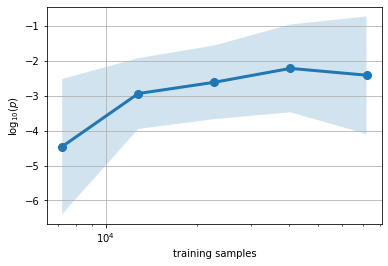

In [62]:
mean_scores = np.mean(test_scores, axis=1)
score_std = np.std(test_scores, axis=1)

plt.plot(
    train_sizes,
    mean_scores,
    marker="o"
)
plt.fill_between(
    train_sizes,
    mean_scores - score_std,
    mean_scores + score_std,
    alpha=0.2
)
plt.semilogx()
plt.xlabel("training samples")
plt.ylabel(r"$\log_{10}(p)$")
plt.grid()

In [63]:
%%time
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

reco_e_score = ReweightedChi2Scorer(
    varname="reco_energy",
    binning=np.geomspace(10., 100., 25),
    reduce="mean"
)

train_sizes_gn, train_scores_gn, test_scores_gn = learning_curve(
    pipe,
    df_all,
    df_all["set"],
    cv=cv,
    n_jobs=4,
    train_sizes=np.geomspace(0.01, 0.1, 5),
    scoring=reco_e_score
)

CPU times: user 962 ms, sys: 77.2 ms, total: 1.04 s
Wall time: 9min 31s


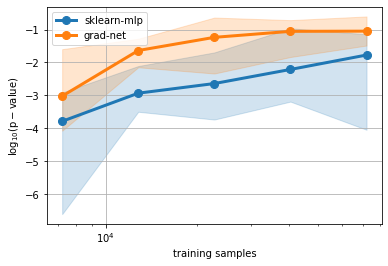

In [66]:
mean_scores_gn = np.mean(test_scores_gn, axis=1)
score_std_gn = np.std(test_scores_gn, axis=1)

plt.plot(
    train_sizes,
    # mean_scores,
    np.median(test_scores, axis=1),
    marker="o",
    color="tab:blue",
    label="sklearn-mlp"
)
plt.fill_between(
    train_sizes,
    # mean_scores - score_std,
    # mean_scores + score_std,
    np.percentile(test_scores, 16, axis=1),
    np.percentile(test_scores, 84, axis=1),
    alpha=0.2,
    color="tab:blue"
)

plt.plot(
    train_sizes_gn,
    # mean_scores_gn,
    np.median(test_scores_gn, axis=1),
    marker="o",
    color="tab:orange",
    label="grad-net"
)
plt.fill_between(
    train_sizes_gn,
    # mean_scores_gn - score_std_gn,
    # mean_scores_gn + score_std_gn,
    np.percentile(test_scores_gn, 16, axis=1),
    np.percentile(test_scores_gn, 84, axis=1),
    alpha=0.2,
    color="tab:orange"
)
# plt.xlim((5e2, 1.1e5))
plt.semilogx()
plt.legend()
plt.xlabel("training samples")
plt.ylabel(r"$\log_{10}({\rm p-value})$")
plt.grid()
# plt.savefig("figures/learning_curve_grad_net_vs_sklearn_v2.pdf")

In [128]:
df_train = df_all.sample(n=100000)

class GradientNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # a network that predicts the gradient w.r.t each systematic parameter
        self.grad_net = nn.Sequential(
            nn.Linear(D, 40),
            nn.Sigmoid(),
            nn.Linear(40, 20),
            nn.Sigmoid(),
            nn.Linear(20, delta_p_poly.shape[0])
        )
        # this matrix is a non-trainable constant
        self.delta_p = torch.from_numpy(delta_p_poly.copy())
        self.delta_p.requires_grad = True

    def forward(self, x):
        grads = self.grad_net(x)
        x = F.softmax(torch.matmul(grads, self.delta_p), dim=1)
        return x
    
net = NeuralNetClassifier(
    GradientNetwork,
    max_epochs=50,
    lr=2e-3,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    optimizer=torch.optim.Adam,
    optimizer__param_groups=[
        # it's important that no decay is applied to biases!
        ('*.bias', {'weight_decay': 0.}),
        ('*.weight', {'weight_decay': 1e-5})
    ],
    batch_size=200,
    warm_start=False,
    # callbacks="disable"
)
pipe = Pipeline(
    [("trafo", trafo), ("net", net)],
)
pipe.fit(df_all, df_all["set"])

[ WARNING] /afs/ifh.de/group/amanda/scratch/trettin/fridge3/pyenv3.7/lib/python3.7/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.1854       0.1463        2.1719  19.4439
      2        2.1713       0.1472        2.1708  18.9786
      3        2.1709       0.1486        2.1701  18.3742
      4        2.1708       0.1478        2.1705  19.6698
      5        2.1707       0.1483        2.1699  19.9119
      6        2.1707       0.1476        2.1699  18.5168
      7        2.1707       0.1482        2.1700  18.6427
      8        2.1706       0.1472        2.1711  19.6618
      9        2.1706       0.1471        2.1705  18.6497
     10        2.1706       0.1475        2.1700  19.5786
     11        2.1707       0.1470        2.1705  18.8068
     12        2.1707       0.1473      

Pipeline(steps=[('trafo',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['reco_energy',
                                                   'true_energy'])])),
                ('net',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=GradientNetwork(
    (grad_net): Sequential(
      (0): Linear(in_features=2, out_features=40, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=40, out_features=20, bias=True)
      (3): Sigmoid()
      (4): Linear(in_features=20, out_features=5, bias=True)
    )
  ),
))])

In [129]:
reco_e_score(pipe, df_all, df_all["set"], return_all=True)

[-0.24376053920715848,
 -0.6543421996475923,
 -0.3698432380191309,
 -2.370270721054351,
 -0.44937633069818944,
 -1.7723158351867037,
 -1.746148279578953,
 -1.5064531768078684]

In [130]:
reco_e_score = ReweightedChi2Scorer(
    varname="reco_energy",
    binning=np.geomspace(10., 100., 25),
    reduce="min"
)
reco_e_score(pipe, df_train, df_train["set"], return_all=True)

[-0.14525958429315564,
 -0.8559845500248975,
 -0.09691934849247708,
 -1.3682528234003872,
 -0.08456617125191966,
 -1.2333297329416886,
 -0.627007171932557,
 -1.7382669297517064]

## Plotting the prediction
The first thing we need to establish is that the probability ratio can actually be reproduced. We choose a given true energy and scan over the reco energy and plot the output from the network.

In [131]:
df_plot = pd.DataFrame({
    "true_energy": 50.,
    "reco_energy": np.linspace(10, 100, 100),
}, dtype=np.float32)
# class predictions aren't super meaningful yet, but a good first step
pipe.predict(df_plot)

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 3, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

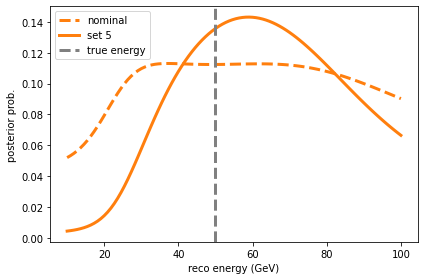

In [132]:
# These are the predicted *posterior* probabilities
set_nr = 5

posterior_nom = pipe.predict_proba(df_plot)[:, 0]
posterior_sys = pipe.predict_proba(df_plot)[:, set_nr]

plt.plot(df_plot["reco_energy"], posterior_nom, label="nominal", color="tab:orange", linestyle="--")
plt.plot(df_plot["reco_energy"], posterior_sys, label=f"set {set_nr}", color="tab:orange")
plt.axvline(x=50, label="true energy", color="gray", linestyle="--")
plt.xlabel("reco energy (GeV)")
plt.ylabel("posterior prob.")
plt.legend(fontsize=10)
plt.tight_layout()
# plt.savefig("figures/mlp_posterior.pdf")

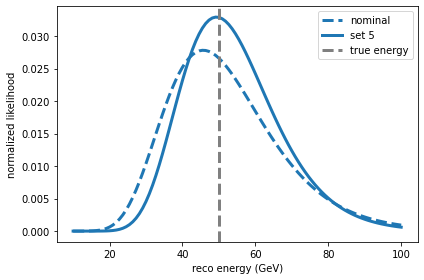

In [133]:
from scipy.stats import lognorm

prob_nom = lognorm.pdf(
    df_plot["reco_energy"],
    nominal_set["shape"],
    loc=0,
    scale=df_plot["true_energy"] * nominal_set["scale"]
)
prob_sys = lognorm.pdf(
    df_plot["reco_energy"],
    sys_sets[set_nr-1]["shape"],
    loc=0,
    scale=df_plot["true_energy"] * sys_sets[set_nr-1]["scale"]
)

prob_sys *= sys_sets[set_nr-1]["scale"] / nominal_set["scale"]

plt.plot(
    df_plot["reco_energy"],
    prob_nom,
    label="nominal",
    color="tab:blue",
    linestyle="--"
)
plt.plot(
    df_plot["reco_energy"],
    prob_sys,
    label=f"set {set_nr}",
    color="tab:blue"
)
plt.axvline(x=50, label="true energy", color="gray", linestyle="--")
plt.xlabel("reco energy (GeV)")
plt.ylabel("normalized likelihood")
plt.legend(fontsize=10)
plt.tight_layout()
# plt.savefig("figures/true_likelihood.pdf")

### Plot the re-weighting ratio
We claimed that the ratio of likelihoods shoul be equal to the ratio of posteriors. We find that that is indeed the case, up to some threshold in energy. If we look at the distributions above, we see that events at these energies or above are exceedingly unlikely, so that the network doesn't see enough examples to estimate the likelihood fraction accurately. That shouldn't be too much of a problem since those events are, by construction, very rare.

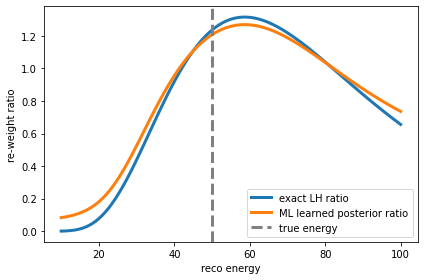

In [134]:
plt.plot(df_plot["reco_energy"], prob_sys / prob_nom, label="exact LH ratio")
plt.plot(df_plot["reco_energy"], posterior_sys / posterior_nom, label="ML learned posterior ratio")
plt.axvline(x=50, label="true energy", color="gray", linestyle="--")
# plt.axhline(y=sys_sets[set_nr-1]["scale"] / nominal_set["scale"], label="class prior", color="gray", linestyle=":")
plt.legend(fontsize=10)
plt.xlabel("reco energy")
plt.ylabel("re-weight ratio")
plt.tight_layout()
# plt.savefig("figures/mlp_reweight_ratio_compare_exact.pdf")

## Emulating any systematic set using the ML learned weights
To put is all together, we should now be able to emulate any systematic set by re-weighting according to the posterior ratio predicted by our model.

In [135]:
df_nom = pd.DataFrame({
    "true_energy": nominal_set["model"].events["true_energy"],
    "reco_energy": nominal_set["model"].events["reco_energy"]
}, dtype=np.float32)
nominal_set_probabilities = pipe.predict_proba(df_nom)
# systematic set to be emulated
set_nr = 8
# calculate the denominator of the ratio
posterior_nominal = nominal_set_probabilities[:, 0]
# calculate the nominator
posterior_sys = nominal_set_probabilities[:, set_nr]
# adjust weights (but don't change the initial weights so we don't have to re-create the model)
nominal_set["model"].events["weights"] = (
    nominal_set["model"].events["initial_weights"] * posterior_sys / posterior_nominal
)

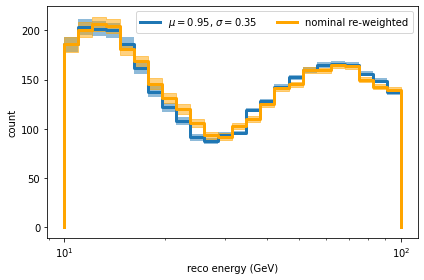

In [136]:
fig = Figure(figsize=(6, 4))
ax = fig.get_ax()

plot_hist(
    ax=ax, hist=sys_sets[set_nr - 1]["model"].get_template(),
    label=fr"$\mu = {sys_sets[set_nr - 1]['scale']}$, $\sigma={sys_sets[set_nr - 1]['shape']}$",
    color=None,
    errors="band"
)
plot_hist(ax=ax, hist=nominal_set["model"].get_template(), label="nominal re-weighted", errors="band")

plt.legend(ncol=2, fontsize=10)
ax.set_xlabel("reco energy (GeV)")
ax.set_ylabel("count")
ax.set_xscale("log")
plt.tight_layout()
# plt.savefig(f"figures/ml_re-weighting_mu_{sys_sets[set_nr - 1]['scale']}_sig_{sys_sets[set_nr - 1]['shape']}.pdf")

In [137]:
hist1 = sys_sets[set_nr - 1]["model"].get_template().hist
vars1 = sys_sets[set_nr - 1]["model"].get_template().variance
hist2 = nominal_set["model"].get_template().hist
vars2 = nominal_set["model"].get_template().variance

print(hist2)
print(vars2)

bin_edges = sys_sets[set_nr - 1]["model"].get_template().bin_edges()

[185.96689907 200.63101332 206.46759517 204.43864556 181.33854614
 168.50013592 145.75974209 131.60077579 120.38019121 106.09360712
  93.37625512  92.18736506 103.21305336 110.05872685 125.04644374
 141.04628997 145.42673211 159.67672802 159.66732261 164.39477826
 163.49909492 149.98527682 142.97141698 139.78367465]
[59.17326612 56.41138245 51.47223261 47.36730963 39.04886066 35.91888847
 30.0729298  25.2334716  22.49486005 19.27514037 13.819014   10.22648979
 10.03596062  8.74578795  6.94722179  8.31584444  6.8089255   7.09062664
  7.02665745  7.04641056  6.87457832  6.19075796  5.77601688  5.52545213]


[]

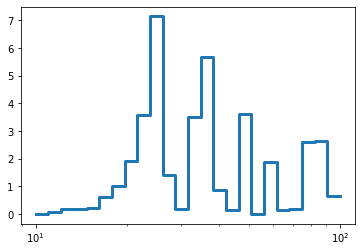

In [138]:
# prepending zero for the step plot
chi2 = np.insert((hist1 - hist2)**2 / (vars1 + vars2), 0, 0)
plt.step(bin_edges, chi2)
plt.semilogx()

In [139]:
chi2 = (hist1 - hist2)**2 / (vars1 + vars2)
print(np.sum(chi2))
np.log1p(-stats.chi2.cdf(np.sum(chi2), df=len(chi2)) + 1e-10) / np.log(10)

38.49566896953529


-1.511086252960877

In [119]:
reco_e_score = ReweightedChi2Scorer(
    varname="reco_energy",
    binning=np.geomspace(10., 100., 25),
    reduce="min"
)